<a href="https://colab.research.google.com/github/4datascience/Traffic/blob/master/Feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!rm -rf sample_data
!sh /content/drive/MyDrive/Traffic/scripts/initialisation.sh

Mounted at /content/drive


#**UPLOAD DATA**

## FROM GOOGLE DRIVE TO GOOGLE DRIVE

In [132]:
import os
import pandas as pd

PREDICTED_MINUTES_AHEAD = 5
if (PREDICTED_MINUTES_AHEAD%5 != 0): raise ValueError("Invalid prediction horizon. Must be multiple of 5 minutes")

training = []
validation = []
total_size = 0

directory = '/content/drive/MyDrive/Traffic/data/processed/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    df=pd.read_csv(f)
    print(f'{filename} {df.shape[0]/(60*24*6)}')
    df["date"] = pd.to_datetime(df["date"], format='%d-%b-%Y %H:%M:%S')
    df = df.set_index("date")
    Y = df.shift(-PREDICTED_MINUTES_AHEAD, freq='min')[['link_id', 'LOS_dep']]
    # Training set
    X = df.loc[(df.index.day < 20)][['link_id', 'tt_arr']]
    training.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    # Validation set
    X = df.loc[~(df.index.day < 20)][['link_id', 'tt_arr']]
    validation.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    total_size += df.shape[0]
del df
training_df = pd.concat(training)
validation_df = pd.concat(validation)

del training, validation
print(f'Training percentage ({training_df.shape[0]} elements):\n\t{training_df.shape[0] / total_size * 100}%')
print(f'Validation percentage:\n\t{validation_df.shape[0] / total_size * 100}%')

training_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_Naive_Bayes_{PREDICTED_MINUTES_AHEAD}m_training.csv')
validation_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_Naive_Bayes_{PREDICTED_MINUTES_AHEAD}m_validating.csv')

Sevilla_2015.csv 365.0
Sevilla_2016.csv 366.0
Sevilla_2017.csv 365.0
Sevilla_2018.csv 273.0
Training percentage (7387200 elements):
	62.45434623813002%
Validation percentage:
	37.54463923382843%


# **NAIVE BAYES**

## **NO FEATURE ENGINEERING**

In [43]:
training_df[training_df['LOS_dep']==4]['link_id'].value_counts()

5     28407
6     20875
10    20101
7     11497
8      8188
9      4173
Name: link_id, dtype: int64

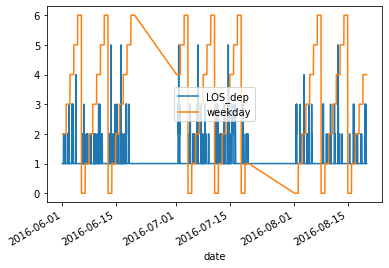

In [108]:
base_df=training_df[training_df['link_id']==9]["2016-05-20":"2016-08-20"]
pd.merge(base_df['LOS_dep'],
pd.DataFrame(list(base_df.index.weekday), index=base_df.index, columns=['weekday']), left_index=True, right_index=True).plot()

# **CLEAN UP**

In [ ]:
!sh /content/drive/MyDrive/Traffic/scripts/logout.sh
drive.flush_and_unmount()